In [1]:
import numpy as np
import roboticstoolbox as rtb
from roboticstoolbox import *
from spatialmath import *
from math import pi
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import cm
import random
import RobotUtils
import copy
%matplotlib notebook

In [2]:
MAX_a = 10
MAX_d = 10
MAX_alpha = np.pi*2
MAX_theta = np.pi*2

Este programa constrói a lógica do Algoritmo Genético que constrói o Robô, o AG1.
O cromossomo segue a estrutura descrita na imagem abaixo.
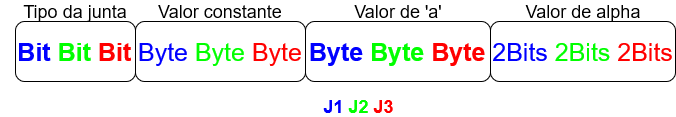

O cromossomo é inteiramente binário. Os 3 primeiros bits são referentes aos tipos das 3 juntas, sendo '1' equivalente a junta de rotação e '0' a junta prismática.
Cada um dos 3 bytes seguintes é referente ao valor constante de cada uma das juntas, sendo esse valor theta, caso a junta seja prismática, e d, caso seja uma junta de rotação. O valor desses parâmetros é discretizado em 256 estados possíveis, assim como os valores de 'a', que são determinados pelos 3 bytes seguintes.
Em seguida, restam 6 bits, sendo cada par de bit destinado para o valor de alpha. Os valores de aplha estão discretizados para múltiplos de pi/2, ou seja, apenas 4 valores.

In [3]:
robot_build_funcs = {'RRR': RobotUtils.robo_RRR,
                    'RRP' : RobotUtils.robo_RRP,
                    'RPR' : RobotUtils.robo_RPR,
                    'RPP' : RobotUtils.robo_RPP,
                    'PRR' : RobotUtils.robo_PRR,
                    'PRP' : RobotUtils.robo_PRP,
                    'PPR' : RobotUtils.robo_PPR,
                    'PPP' : RobotUtils.robo_PPP}

In [4]:
#funcoes de construcoes a partir dos cromossomos
def birth_robot(cromossomo):
#     for i in range(2, 57, 8):
    const_list = [sum([(2**j) if cromossomo[j+i] else 0 for j in range(8)]) for i in range(3, 27, 8)]
    a_list = [sum([(2**j) if cromossomo[j+i] else 0 for j in range(8)]) for i in range(27, 51, 8)]
    juntas = cromossomo[:3]
    alpha_list = [sum([(2**j) if cromossomo[j+i] else 0 for j in range(2)]) for i in range(51, 57, 2)]
    for i in range(3):
        const_list[i] = const_list[i]*MAX_d/255.0 if juntas[i] else const_list[i]*MAX_theta/255.0
        
        alpha_list[i] = alpha_list[i]*MAX_alpha/4.0
        a_list[i] = a_list[i]*MAX_a/255.0
    
    strRobot = ''
    for i in cromossomo[:3]:
        strRobot += 'R' if i else 'P'
    robo = robot_build_funcs[strRobot]('',const_list,a_list,alpha_list)
    return robo,cromossomo[:3]

def move_robot(robot,cromossomo,juntas_bool):
    '''
    Parameters:
    :param robot (roboticstoolbox Robot)
    :param cromossomo (bool de 3 bytes): cada byte representa uma junta 
    :param juntas_bool (bool de 3 bits): cada bool representa o tipo de junta:
    - True para junta de rotação
    - False para junta prismática
    
    Output:
    
    '''
    q_list = [sum([(2**j) if cromossomo[j+i] else 0 for j in range(8)]) for i in range(0,24,8)]
    num_juntas=len(juntas_bool)
    
    q_list=[(q_list[i]/255)*MAX_theta if juntas_bool[i] else (q_list[i]/255)*MAX_d for i in range(num_juntas)]
    H=robot.fkine(q_list)
            
    return H

def point_H(H):
    return np.array(H.A[0:3,3])

In [13]:
class AG3Int:
    def __init__(self,num_crs,robot,boolJuntas,Juntas_init,P0,mut_rate,co_tech,sel_tech,to_kill_perc):
        '''
        Parameters:
        :param co_tech (str): technique of crossover used in this GA
        - 'OP' for one point
        - 'MPX' for multipoint, with X cross points
        - 'U' for uniform
        :param sel_tech (str) technique of selection used in this GA
        - 'EL' for elitism
        - 'TN' for N-branch tournament selection 
        :param mut_rate (int or dict): number of genes to mutate over each new solution (after selection)
        
        1) if it is a dict, then: mut_rate={limiar1:mut_rat1,limiar2:mut_rate2 (...) limiarN:mut_rateN}
        - basicallly, if the number of generations without improvement gets to limiar1, then the
        mutation rate is updated to mut_rat1...the same thing applies to mut_rate2...mut_rateN
        
        2) if it is a int, then the mutation rate of the GA is constant and equals to mut_rate
        '''
        #parametros do robo
        self.robot=robot
        self.boolJuntas=boolJuntas
        self.individuals=[]
        self.num_crs=num_crs
        self.P0=P0
        
        if(isinstance(mut_rate,dict)):
            self.mut_rate_dict=mut_rate
            self.mut_rate=mut_rate[0]
        else:
            self.mut_rate_dict=None
            self.mut_rate=mut_rate
            
        self.co_tech=co_tech
        self.sel_tech=sel_tech
        self.to_kill_perc=to_kill_perc
        self.initial_pos=Juntas_init
        
        self.create_new_individuals(initial_pos=Juntas_init)    
    
    def dist(self,P):
        return np.abs(np.sqrt((P[0]-self.P0[0])**2+(P[1]-self.P0[1])**2+(P[2]-self.P0[2])**2))
    
    def create_new_individuals(self,initial_pos=None,individual_list=None,num_elems=None,delete=False):
        if(delete==True):
            self.individuals=[]
        if(num_elems==None):
            num_elems=self.num_crs
        for i in range(num_elems):
            if(individual_list==None):
                if initial_pos!=None:
                    initial_mutation = np.random.randint(3, size=(3,), dtype=int)
                    self.individuals.append({'cr':np.array([initial_pos[k]+(-1)**initial_mutation[k] for k in range(3)])})# precisao de 0.1 grau
                else:
                    self.individuals.append({'cr':np.random.randint(3600, size=(3,), dtype=int)})
            else:
                if self.initial_pos!=None:
                    initial_mutation = np.random.randint(3, size=(3,), dtype=int)
                    self.individuals.append({'cr':np.array([self.initial_pos[k]+(-1)**initial_mutation[k] for k in range(3)])})
                else:
                    self.individuals.append({'cr':np.random.randint(3600, size=(3,), dtype=int)})
    
    def evaluate_one(self,ind_idx):
        P=self.robot.fkine(self.individuals[ind_idx]['cr']).A[0:3,3]
        self.individuals[ind_idx]['score']=self.dist(P)
        
    def evaluate_all(self):
        for i in range(self.num_crs):
            self.evaluate_one(i)
            
    def get_mean(self):
        self.mean=np.mean(list(map(lambda x:x['score'],self.individuals)))
        
    def get_best_individual(self):
        try:
            best_idx_bef=self.best_idx
        except:
            best_idx_bef=-1 #invalido, para mostrar que nao havia sido calculado o best_individual ainda
            
        self.best_score=1e9
        for i in range(self.num_crs):
            try:
                score=self.individuals[i]['score'] 
            except:
                self.evaluate_one(i)
                score=self.individuals[i]['score']
            if(score < self.best_score):
                self.best_idx=i
                self.best_score=score
        if(self.best_idx!=best_idx_bef):
            self.num_without_imp=0
        else:
            self.num_without_imp+=1
            
        
                
    def crossover(self,ind_idx1,ind_idx2,weight1=0.5):
        '''
        Crossover between two individuals, with index ind_idx1 and ind_idx2.
        
        Parameters:
        :param ind_idx1 (int): index of the first individual (as in self.individuals list)
        :param ind_idx2 (int): index of the second individual (as in self.individuals list)
        '''
        cr1=list(self.individuals[ind_idx1]['cr'])
        cr2=list(self.individuals[ind_idx2]['cr'])

        
        if(self.co_tech=='AVG'):
            new_ind=[(weight1*cr1[cr_idx]+(1-weight1)*cr2[cr_idx]) for cr_idx in range(len(cr1))]
            if(self.individuals[ind_idx1]['score'] > self.individuals[ind_idx2]['score']):
                self.individuals[ind_idx1]['cr']=np.array(new_ind)
            else:
                self.individuals[ind_idx2]['cr']=np.array(new_ind)
                
        if(self.co_tech=='BST'):
            if(self.individuals[ind_idx1]['score'] < self.individuals[ind_idx2]['score']):
                self.individuals[ind_idx2]['cr']=self.individuals[ind_idx1]['cr']
            else:
                self.individuals[ind_idx1]['cr']=new_ind=self.individuals[ind_idx2]['cr']
                
        if(self.co_tech=='RAN'):
            if(random.random()<0.5):
                self.individuals[ind_idx2]['cr']=self.individuals[ind_idx1]['cr']
            else:
                self.individuals[ind_idx1]['cr']=new_ind=self.individuals[ind_idx2]['cr']
        
    def selection(self):
        self.evaluate_all()
        self.get_best_individual() #retorna o indice do melhor de todos em self.best_idx
        self.get_mean() #retorna a media em self.mean
        if(self.sel_tech=='EL'):
            for cr_idx in range(self.num_crs):
                if(cr_idx!=self.best_idx): #nao sei se tem algum jeito mais esperto do que testar todos
                    self.crossover(self.best_idx,cr_idx,0.75) #75% de peso para o melhor de todos
                    self.mutation
        elif(self.sel_tech[0]=='T'): #tournament
            N=int(self.sel_tech[1]) #tournament of N
            idx_list=random.sample(range(self.num_crs),2*N) #parents at random
            best_sol=1e9
            for idx in idx_list[0:N]:
                if(self.individuals[idx]['score']<best_sol):
                    par1=idx
                
            best_sol=1e9
            for idx in idx_list[N:]:
                if(self.individuals[idx]['score']<best_sol):
                    par2=idx
                
            self.crossover(par1,par2,0.5)   
        
    def change_mutation_rate(self):
        self.mut_rate=self.mut_rate_dict[0]
        for key in list(self.mut_rate_dict.keys()):
            if(key>self.num_without_imp):
                break
            self.mut_rate=self.mut_rate_dict[key]      
        
    def mutation(self):
        if(self.mut_rate!=0):
            for cr_idx in range(self.num_crs):
                if(cr_idx!=self.best_idx):
                    if(random.random() <= self.mut_rate):
                        for gen_idx in range(len(self.individuals[cr_idx]['cr'])):
                            self.individuals[cr_idx]['cr'][gen_idx]+=np.random.normal(loc=0,scale=0.05)*self.individuals[cr_idx]['cr'][gen_idx]

    def kill_worst_elems(self):
        self.individuals.sort(key=lambda x:x['score'])
        to_kill=int(self.num_crs*self.to_kill_perc)
        del self.individuals[-1:-(1+to_kill):-1]
        self.create_new_individuals(num_elems=to_kill)
                  
    def run(self,num_iters):
        self.best_score_list=[]
        self.mean_list=[]
        for i in range(num_iters):
            self.selection()
            if(self.mut_rate_dict!=None):
                self.change_mutation_rate()
            self.mutation()
            self.kill_worst_elems()
            self.best_score_list.append(self.best_score)
            self.mean_list.append(self.mean)
            #print(self.num_without_imp,self.mut_rate)

Text(0.5, 1.0, 'Melhor x media, sel=EL, co=AVG')

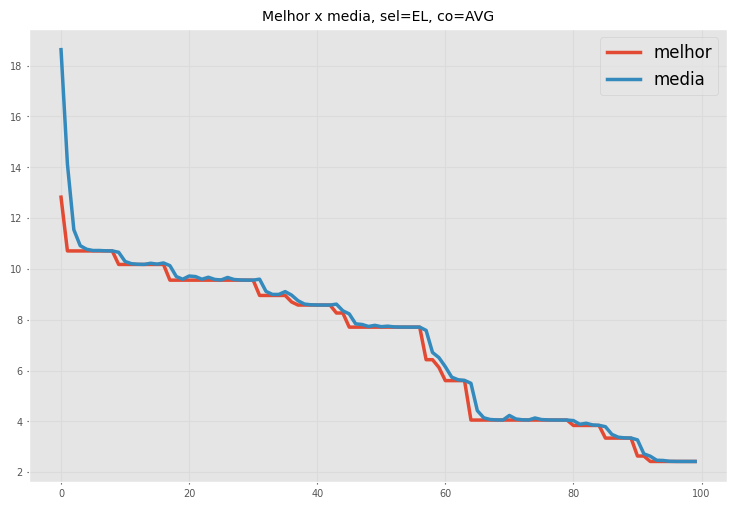

In [32]:
#criando um ponto teste 
construct_cr = np.random.randint(2, size=(57,), dtype=bool)
move_cr=np.random.randint(2, size=(24,), dtype=bool)
[robot,boolJuntas] = birth_robot(construct_cr)
H=move_robot(robot,move_cr,boolJuntas)
P1=point_H(H)
#P1=np.array([8,8,8])

juntas_init=[0,0,0]

#parametros do AG3
num_iters=100 #numero de iteracoes
num_inds=10 #numero de individuos
sel_tech='EL' # 'EL' or 'TN'
co_tech='AVG' # 'AVG' or 'BST' or 'RAN'
#mut_rate={0:0.02,5:0.05,10:0.1,15:0.2,50:0.3,100:0.4,200:0.5}
mut_rate=0.05
ag3_int = AG3Int(num_inds,robot,boolJuntas,juntas_init,P1,mut_rate,co_tech,sel_tech,0)
ag3_int.run(num_iters)
fig=plt.figure(figsize=(9,6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(range(num_iters),ag3_int.best_score_list,linewidth=2.5,label='melhor')
plt.plot(range(num_iters),ag3_int.mean_list,linewidth=2.5,label='media')
plt.legend(fontsize=12)
plt.title("Melhor x media, sel={}, co={}".format(sel_tech,co_tech))


In [307]:
ag3_int.individuals

[{'cr': array([5.99993695, 4.83895486, 1.96926109]),
  'score': 0.1426463428768713},
 {'cr': array([5.59670892, 4.41065015, 1.75419377]),
  'score': 1.6274568524379598},
 {'cr': array([5.69956848, 4.78114052, 1.96226708]),
  'score': 1.8425023830351155},
 {'cr': array([5.8546368 , 3.07463496, 1.68483738]),
  'score': 1.9883983036075836},
 {'cr': array([6.27696337, 3.64824667, 1.54311423]),
  'score': 4.460948309044046},
 {'cr': array([5.33851405, 6.07215693, 2.6150468 ]),
  'score': 4.762603062639457},
 {'cr': array([6.07709003, 5.2209682 , 1.58285185]),
  'score': 5.463285170723387},
 {'cr': array([5.61240564, 4.32870657, 1.87163261]),
  'score': 5.797170884751808},
 {'cr': array([6.29735191, 5.19372203, 1.85657702]),
  'score': 5.969058640651329},
 {'cr': array([4.92946702, 6.25240701, 2.43856081]),
  'score': 7.317977594691557}]

Text(0.5, 1.0, 'Evolucao do melhor de todos - diferentes taxas de mutacao')

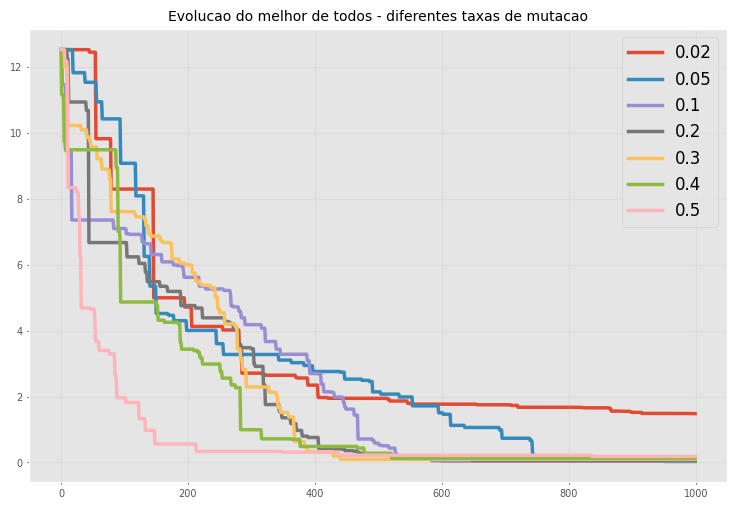

In [311]:
#criando um ponto teste 

construct_cr = np.random.randint(2, size=(57,), dtype=bool)
move_cr=np.random.randint(2, size=(24,), dtype=bool)
[robot,boolJuntas] = birth_robot(construct_cr)
H=move_robot(robot,move_cr,boolJuntas)
P1=point_H(H) 

#posicao inicial das juntas (seria o ponto anterior da trajetoria)
juntas_init=[5,5,5]

#parametros do AG3
fig=plt.figure(figsize=(9,6), dpi= 100, facecolor='w', edgecolor='k')
mut_rate_list=[0.02,0.05,0.1,0.2,0.3,0.4,0.5]
for mut_rate in mut_rate_list:
    num_iters=1000 #numero de iteracoes
    num_inds=10 #numero de individuos
    sel_tech='T4' # 'EL' or 'TN' OBS: so acompanha a media de forma rigida se for elitimos (isso ja era esperado)
    co_tech='AVG' # 'AVG' or 'BST' or 'RAN'
    #mut_rate={0:1,5:2,10:3,15:4,50:5,100:10,200:20}
    #mut_rate=0.05
    ag3_int = AG3Int(num_inds,robot,boolJuntas,juntas_init,P1,mut_rate,co_tech,sel_tech,0)
    ag3_int.run(num_iters)

    plt.plot(range(num_iters),ag3_int.best_score_list,linewidth=2.5,label=mut_rate)
    #plt.plot(range(num_iters),ag3_int.mean_list,linewidth=2.5,label=mut_rate)
plt.legend(fontsize=12)
plt.title('Evolucao do melhor de todos - diferentes taxas de mutacao')


In [127]:
class AG3:
    def __init__(self,num_crs,robot,boolJuntas,P0,mut_rate,co_tech,sel_tech,to_kill_perc):
        '''
        Parameters:
        :param co_tech (str): technique of crossover used in this GA
        - 'OP' for one point
        - 'MPX' for multipoint, with X cross points
        - 'U' for uniform
        :param sel_tech (str) technique of selection used in this GA
        - 'EL' for elitism
        - 'TN' for N-branch tournament selection 
        :param mut_rate (int or dict): number of genes to mutate over each new solution (after selection)     
        1) if it is a dict, then: mut_rate={limiar1:mut_rat1,limiar2:mut_rate2 (...) limiarN:mut_rateN}
        - basicallly, if the number of generations without improvement gets to limiar1, then the
        mutation rate is updated to mut_rat1...the same thing applies to mut_rate2...mut_rateN
        
        2) if it is a int, then the mutation rate of the GA is constant and equals to mut_rate
        :param boolJuntas (bool de 3 bits): cada bool representa o tipo de junta:
        - True para junta de rotação
        - False para junta prismática          
       '''
        #parametros do robo
        self.robot=robot
        self.boolJuntas=boolJuntas
        self.individuals=[]
        self.num_crs=num_crs
        self.P0=P0
        if(isinstance(mut_rate,dict)):
            self.mut_rate_dict=mut_rate
            self.mut_rate=mut_rate[0]
        else:
            self.mut_rate_dict=None
            self.mut_rate=mut_rate
            
        self.co_tech=co_tech
        self.sel_tech=sel_tech
        self.to_kill_perc=to_kill_perc
        
        self.create_new_individuals()
            
            
    def pos_from_move(self,ind_idx):
        '''
        Parameters:
        :param robot (roboticstoolbox Robot)
        :param cromossomo (bool de 3 bytes): cada byte representa uma junta 


        Output:

        '''
        q_list = [sum([(2**j) if self.individuals[ind_idx]['cr'][j+i] else 0 for j in range(8)]) for i in range(0,24,8)]
        num_juntas=len(self.boolJuntas)

        q_list=[(q_list[i]/255)*MAX_theta if self.boolJuntas[i] else (q_list[i]/255)*MAX_d for i in range(num_juntas)]
        H=self.robot.fkine(q_list)

        return np.array(H.A[0:3,3])     
    
    def dist(self,P):
        return np.abs(np.sqrt((P[0]-self.P0[0])**2+(P[1]-self.P0[1])**2+(P[2]-self.P0[2])**2))
    
    def create_new_individuals(self,individual_list=None,num_elems=None,delete=False):
        if(delete==True):
            self.individuals=[]
        if(num_elems==None):
            num_elems=self.num_crs
        for i in range(num_elems):
            if(individual_list==None):
                self.individuals.append({'cr':np.random.randint(2, size=(24,), dtype=bool)})
            else:
                self.individuals.append({'cr':individual_list[i]})
    
    def evaluate_one(self,ind_idx):
        P=self.pos_from_move(ind_idx)
        self.individuals[ind_idx]['score']=self.dist(P)
        
    def evaluate_all(self):
        for i in range(self.num_crs):
            self.evaluate_one(i)
            
    def get_mean(self):
        self.mean=np.mean(list(map(lambda x:x['score'],self.individuals)))
        
    def get_best_individual(self):
        try:
            best_idx_bef=self.best_idx
        except:
            best_idx_bef=-1 #invalido, para mostrar que nao havia sido calculado o best_individual ainda
            
        self.best_score=1e9
        for i in range(self.num_crs):
            try:
                score=self.individuals[i]['score'] 
            except:
                self.evaluate_one(i)
                score=self.individuals[i]['score']
            if(score < self.best_score):
                self.best_idx=i
                self.best_score=score
        if(self.best_idx!=best_idx_bef):
            self.num_without_imp=0
        else:
            self.num_without_imp+=1
            
        
                
    def crossover(self,ind_idx1,ind_idx2,bias_1):
        '''
        Crossover between two individuals, with index ind_idx1 and ind_idx2.
        
        Parameters:
        :param ind_idx1 (int): index of the first individual (as in self.individuals list)
        :param ind_idx2 (int): index of the second individual (as in self.individuals list)
        :param bias_1 (float): bias to select the genes from the first individual.
        - If bias_1=0.75, there is a 75% chance of the child getting its cromossomes from individual 1 
        (and, consequently 25% chance to get it from individual 2)
        '''
        cr1=list(self.individuals[ind_idx1]['cr'])
        cr2=list(self.individuals[ind_idx2]['cr'])
        new_ind=[]
        
        if(self.co_tech[0:2]=='MP'):
            num_cp=int(self.co_tech[2])
            cps=list(np.random.randint(0,24,num_cp))
            cps.append(0) #getting the first cut on the beginning of the cromossome
            cps.append(24) #getting the last cut on the end of the cromossome
            cps.sort()
            
            for cp_idx in range(num_cp+1):
                if(random.random() < bias_1): #select the first individual
                    #print("individuo 1")
                    new_ind+=cr1[cps[cp_idx]:cps[cp_idx+1]]
                else:
                    #print("individuo 2")
                    new_ind+=cr2[cps[cp_idx]:cps[cp_idx+1]]
                    
        elif(self.co_tech=='OP'):
            cps=[0,random.randint(0,23),24] #selecting the crosspoint
            new_ind=[]
            for cp_idx in range(2): #only one crosspoint (thus, two segments)
                if(random.random() < bias_1):
                    new_ind+=cr1[cps[cp_idx]:cps[cp_idx+1]]
                else:
                    new_ind+=cr2[cps[cp_idx]:cps[cp_idx+1]]
        
        elif(self.co_tech=='U'):
            for point in range(24):
                if(random.random() < bias_1): #select the first individual
                    #print("individuo 1")
                    new_ind.append(cr1[point])
                else:
                    #print("individuo 2")
                    new_ind.append(cr2[point])
        
        if(self.individuals[ind_idx1]['score'] > self.individuals[ind_idx2]['score']):
            self.individuals[ind_idx1]['cr']=np.array(new_ind)
        else:
            self.individuals[ind_idx2]['cr']=np.array(new_ind)
    
    def selection(self):
        self.evaluate_all()
        self.get_best_individual() #retorna o indice do melhor de todos em self.best_idx
        self.get_mean() #retorna a media em self.mean
        if(self.sel_tech=='EL'):
            for cr_idx in range(self.num_crs):
                if(cr_idx!=self.best_idx): #nao sei se tem algum jeito mais esperto do que testar todos
                    self.crossover(self.best_idx,cr_idx,0.75) #75% de chance de pegar o melhor de todos
                    self.mutation
        elif(self.sel_tech[0]=='T'): #tournament
            N=int(self.sel_tech[1]) #tournament of N
            idx_list=random.sample(range(self.num_crs),2*N) #parents at random
            best_sol=1e9
            for idx in idx_list[0:N]:
                if(self.individuals[idx]['score']<best_sol):
                    par1=idx
                
            best_sol=1e9
            for idx in idx_list[N:]:
                if(self.individuals[idx]['score']<best_sol):
                    par2=idx
                
            self.crossover(par1,par2,0.5)   
        
    def change_mutation_rate(self):
        self.mut_rate=self.mut_rate_dict[0]
        for key in list(self.mut_rate_dict.keys()):
            if(key>self.num_without_imp):
                break
            self.mut_rate=self.mut_rate_dict[key]      
        
    def mutation(self):
        if(self.mut_rate!=0):
            for cr_idx in range(self.num_crs):
                gens_to_mutate=np.random.randint(0,24,self.mut_rate)
                for gen_to_mutate in list(gens_to_mutate):
                    if(cr_idx!=self.best_idx):
                        self.individuals[cr_idx]['cr'][gen_to_mutate] = not self.individuals[cr_idx]['cr'][gen_to_mutate]
        
    def kill_worst_elems(self):
        self.individuals.sort(key=lambda x:x['score'])
        to_kill=int(self.num_crs*self.to_kill_perc)
        del self.individuals[-1:-(1+to_kill):-1]
        self.create_new_individuals(num_elems=to_kill)
        pass
                  
    def run(self,num_iters):
        self.best_score_list=[]
        self.mean_list=[]
        for i in range(num_iters):
            self.selection()
            if(self.mut_rate_dict!=None):
                self.change_mutation_rate()
            self.mutation()
            self.kill_worst_elems()
            self.best_score_list.append(self.best_score)
            self.mean_list.append(self.mean)
            #print(self.num_without_imp,self.mut_rate)

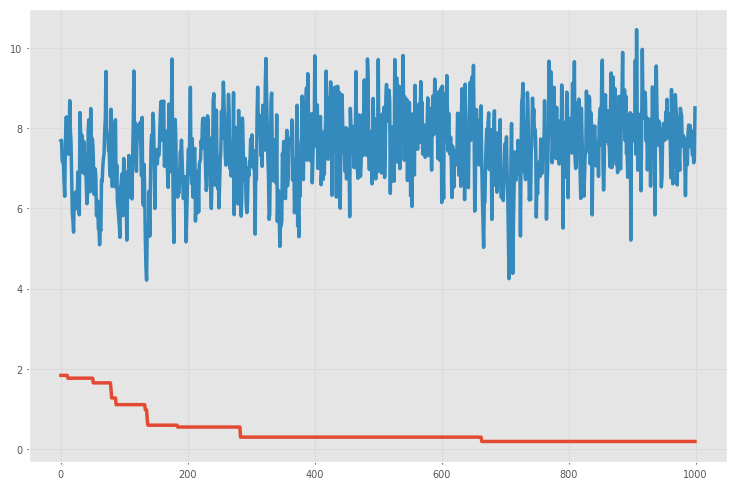

In [6]:
#criando um ponto teste 

construct_cr = np.random.randint(2, size=(57,), dtype=bool)
move_cr=np.random.randint(2, size=(24,), dtype=bool)
[robot,boolJuntas] = birth_robot(construct_cr)
H=move_robot(robot,move_cr,boolJuntas)
P1=point_H(H)
#P1=np.array([8,8,8])

#parametros do AG3
num_iters=1000 #numero de iteracoes
num_inds=10 #numero de individuos
sel_tech='T3' # 'EL' or 'TN'
co_tech='MP4' # 'U' or 'OP' or 'MPN'
mut_rate={0:1,5:2,10:3,15:4,50:5,100:10,200:20}
#mut_rate=4
ag3 = AG3(num_inds,robot,boolJuntas,P1,mut_rate,co_tech,sel_tech,0.1)
ag3.run(num_iters)
fig=plt.figure(figsize=(9,6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(range(num_iters),ag3.best_score_list,linewidth=2.5,label=sel_tech)
plt.plot(range(num_iters),ag3.mean_list,linewidth=2.5,label=sel_tech)

In [7]:
ag3.individuals

[{'cr': array([ True,  True, False, False,  True, False, False, False, False,
         False,  True,  True, False, False,  True,  True, False, False,
         False, False,  True, False, False, False]),
  'score': 0.18617040036218577},
 {'cr': array([ True,  True, False,  True,  True, False,  True, False,  True,
          True,  True,  True,  True,  True, False, False,  True, False,
         False,  True,  True,  True,  True, False]),
  'score': 5.172085019317417},
 {'cr': array([ True,  True, False,  True, False,  True, False,  True,  True,
         False, False, False, False, False,  True,  True,  True,  True,
         False, False, False,  True,  True, False]),
  'score': 8.727233878005356},
 {'cr': array([ True, False,  True, False, False,  True, False, False,  True,
         False,  True, False, False,  True, False, False, False,  True,
         False, False, False, False, False,  True]),
  'score': 8.85085528744391},
 {'cr': array([ True, False, False, False, False, False, False,

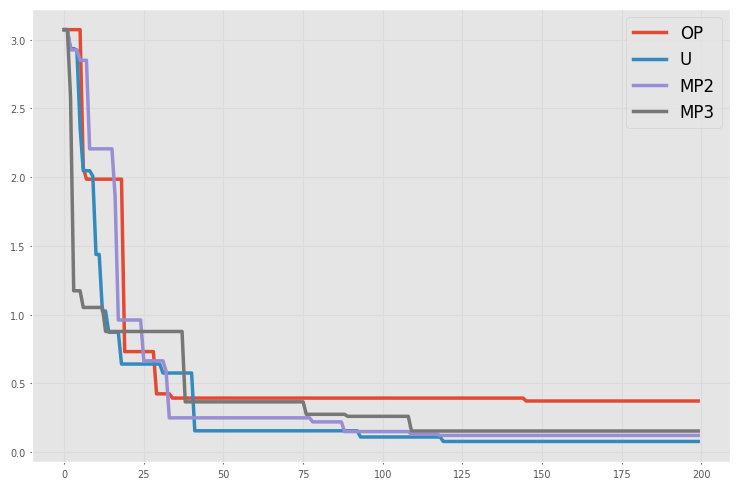

In [8]:
H=move_robot(robot,move_cr,boolJuntas)
P1=point_H(H)
sel_tech_list=['OP','U','MP2','MP3']
best_score_dict={}
for sel_tech in sel_tech_list:
    ag3 = AG3(5,robot,boolJuntas,P1,5,'MP3','EL',0)
    if(sel_tech=='OP'):
        individual_list=[ag3.individuals[cr_idx]['cr'] for cr_idx in range(ag3.num_crs)]
    else:
        ag3.create_new_individuals(individual_list,delete=True)
    ag3.evaluate_all()
    ag3.get_best_individual()
    #ag3.best_score #melhor score da geracao inicial
    num_iters=200
    ag3.run(num_iters)
    best_score_dict[sel_tech]=ag3.best_score_list

fig=plt.figure(figsize=(9,6), dpi= 100, facecolor='w', edgecolor='k')
for (sel_tech,best_score_list) in best_score_dict.items():
    plt.plot(range(num_iters),best_score_list,linewidth=2.5,label=sel_tech)
plt.legend(fontsize=12)
plt.show()



In [11]:
construct_cr = np.random.randint(2, size=(57,), dtype=bool)
[robo,juntas_robo] = birth_robot(construct_cr)